In [1]:
# !pip install gensim
# !pip install sklearn
# !pip install matplotlib

from gensim import models
import pandas as pd 
import numpy as np

wordvec = models.KeyedVectors.load_word2vec_format('data/ch7/GoogleNews-vectors-negative300.bin.gz', binary=True)

train = pd.read_csv('data/ch8/NewsAggregatorDataset/train.txt', sep='\t', header=None)
valid = pd.read_csv('data/ch8/NewsAggregatorDataset/valid.txt', sep='\t', header=None)
test = pd.read_csv('data/ch8/NewsAggregatorDataset/test.txt', sep='\t', header=None)

train.columns = ['TITLE', 'CATEGORY']
valid.columns = ['TITLE', 'CATEGORY']
test.columns  = ['TITLE', 'CATEGORY']

In [2]:
'''70. 単語ベクトルの和による特徴量
問題50で構築した学習データ，検証データ，評価データを行列・ベクトルに変換したい．
例えば，学習データについて，すべての事例xiの特徴ベクトルxiを並べた行列Xと，
正解ラベルを並べた行列（ベクトル）Yを作成したい．'''

import numpy as np
import pandas as pd 

def text2vec(data, wordvec):  
    vecs = []
    for index,row in data.iterrows():
        vec = [wordvec[word] for word in row['TITLE'].split() if word in wordvec]
        if len(vec) < 1:   # if no words in word2vec, assign 0
            vecs.append(np.zeros(wordvec.vector_size))
        else:
            vecs.append(np.mean(vec,axis=0))
    return vecs

train_feature = pd.DataFrame(text2vec(train, wordvec))
valid_feature = pd.DataFrame(text2vec(valid, wordvec))
test_feature = pd.DataFrame(text2vec(test, wordvec))

train_feature.to_csv('data/ch8/NewsAggregatorDataset/train.feature.txt', sep='\t', index=False, header=None)
valid_feature.to_csv('data/ch8/NewsAggregatorDataset/valid.feature.txt', sep='\t', index=False, header=None)
test_feature.to_csv('data/ch8/NewsAggregatorDataset/test.feature.txt',   sep='\t', index=False, header=None)

In [1]:
'''71. 単層ニューラルネットワークによる予測
問題70で保存した行列を読み込み，学習データについて以下の計算を実行せよ'''
import torch
import pandas as pd 

label_map = {'b':0,'e':1,'t':2,'m':3}

X_train = pd.read_csv('data/ch8/NewsAggregatorDataset/train.feature.txt',sep='\t', header=None)
y_train = pd.read_csv('data/ch8/NewsAggregatorDataset/train.txt',sep='\t', header=None).replace({1: label_map})[1]

X_valid = pd.read_csv('data/ch8/NewsAggregatorDataset/valid.feature.txt',sep='\t', header=None)
y_valid = pd.read_csv('data/ch8/NewsAggregatorDataset/valid.txt',sep='\t', header=None).replace({1: label_map})[1]

X_test = pd.read_csv('data/ch8/NewsAggregatorDataset/test.feature.txt',sep='\t', header=None)
y_test = pd.read_csv('data/ch8/NewsAggregatorDataset/test.txt',sep='\t', header=None).replace({1: label_map})[1]

# X_test = X_test.loc[(X_test != 0).any(axis=1),:]
print(len(y_train),len(y_valid),len(y_test))
print(len(X_train),len(X_valid),len(X_test))
print(X_train.shape)

X_Train = torch.tensor(X_train.values, dtype=torch.float32)
Y_Train = torch.tensor(y_train.values, dtype=torch.int64)

W = torch.randn(300, len(label_map))  # input_dim, output_dim
softmax = torch.nn.Softmax(dim=1)
Y = softmax(torch.matmul(X_Train[:4], W))
print(Y)

10672 1334 1334
10672 1334 1334
(10672, 300)
tensor([[0.0061, 0.0137, 0.0111, 0.9691],
        [0.0080, 0.0022, 0.0232, 0.9666],
        [0.0813, 0.2573, 0.1491, 0.5123],
        [0.0152, 0.1209, 0.0280, 0.8359]])


In [3]:
'''72. 損失と勾配の計算
学習データの事例x1と事例集合x1,x2,x3,x4に対して，
クロスエントロピー損失と，行列Wに対する勾配を計算せよ．
なお，ある事例xiに対して損失は次式で計算される'''
from torch import nn
import numpy as np

W = torch.randn(300, 4)
softmax = torch.nn.Softmax(dim=1)
Y = (torch.matmul(X_Train[:4], W))

loss_fn = nn.CrossEntropyLoss()
loss = loss_fn(Y, Y_Train[:4])
print(loss)

cross_entropy = []
# check cross_entropy
for pred,true_label in zip(softmax(torch.matmul(X_Train[:4], W)),Y_Train[:4]):
    cross_entropy.append(-np.log(pred[true_label]))
print(np.mean(cross_entropy))

tensor(0.6583)
0.658319


In [37]:
'''73. 確率的勾配降下法による学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて
，行列Wを学習せよ．なお，学習は適当な基準で終了させればよい
（例えば「100エポックで終了」など）．'''
from torch import optim

class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = self.linear(x)
        return outputs
    
model = LogisticRegression(300, 4)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

for epoch in range(100):
    optimizer.zero_grad()
    y_pred = model(X_Train)
    loss = loss_fn(y_pred, Y_Train)
    loss.backward()
    optimizer.step()

print(loss)

tensor(1.2272, grad_fn=<NllLossBackward>)


In [38]:
'''74. 正解率の計測
問題73で求めた行列を用いて学習データおよび評価データの事例を分類したとき，
その正解率をそれぞれ求めよ．'''

X_Test = torch.tensor(X_test.values, dtype=torch.float32)
Y_Test = torch.tensor(y_test.values, dtype=torch.int64)

_, y_pred_trn = torch.max(model(X_Train), 1)
print('training acc: ',(y_pred_trn == Y_Train).sum().item() / len(Y_Train))

_, y_pred_tst = torch.max(model(X_Test), 1)
print('testing acc: ',(y_pred_tst == Y_Test).sum().item() / len(Y_Test))

training acc:  0.7399737631184408
testing acc:  0.7263868065967016


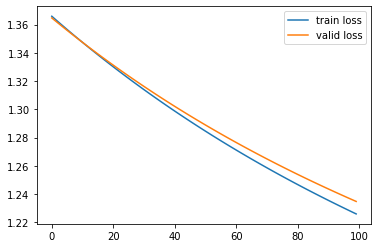

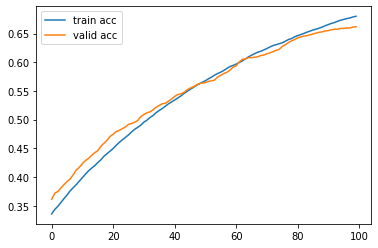

In [43]:
'''75. 損失と正解率のプロット
問題73のコードを改変し，各エポックのパラメータ更新が完了するたびに，
訓練データでの損失，正解率，検証データでの損失，正解率をグラフにプロットし，
学習の進捗状況を確認できるようにせよ．'''

'''76. チェックポイント
問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，
チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態
）をファイルに書き出せ．'''

import matplotlib.pyplot as plt

X_Valid = torch.tensor(X_valid.values, dtype=torch.float32)
Y_Valid = torch.tensor(y_valid.values, dtype=torch.int64)

class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = self.linear(x)
        return outputs
    
model = LogisticRegression(300, 4)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

for epoch in range(100):
    optimizer.zero_grad()
    y_pred = model(X_Train)
    loss = loss_fn(y_pred, Y_Train)
    train_loss.append(loss)
    loss.backward()
    optimizer.step()    
    with torch.no_grad():
        valid_loss.append(loss_fn(model(X_Valid), Y_Valid))
        _, y_pred_trn = torch.max(model(X_Train), 1)
        train_acc.append((y_pred_trn == Y_Train).sum().item() / len(Y_Train))

        _, y_pred_val = torch.max(model(X_Valid), 1)
        valid_acc.append((y_pred_val == Y_Valid).sum().item() / len(Y_Valid))
    
    if (epoch % 20) == 0 and epoch > 0:   # save model state every 20 epochs
        state = {'epoch': epoch + 1, 'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(),}
        torch.save(state, 'data/ch8/model/{}_checkpoint'.format(epoch+1))        


plt.plot(train_loss, label='train loss')
plt.plot(valid_loss, label='valid loss')
plt.legend()
plt.show()

plt.plot(train_acc, label='train acc')
plt.plot(valid_acc, label='valid acc')
plt.legend()
plt.show()

In [37]:
'''76. チェックポイント
問題75のコードを改変し，各エポックのパラメータ更新が完了するたびに，
チェックポイント（学習途中のパラメータ（重み行列など）の値や最適化アルゴリズムの内部状態
）をファイルに書き出せ．'''

import os

def load_checkpoint(model, optimizer, filename='checkpoint'):
    # Note: Input model & optimizer should be pre-defined.  This routine only updates their states.
    start_epoch = 0
    if os.path.isfile(filename):
        print("=> loading checkpoint '{}'".format(filename))
        checkpoint = torch.load(filename)
        start_epoch = checkpoint['epoch']
        model.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        print("=> loaded checkpoint '{}' (epoch {})"
                  .format(filename, checkpoint['epoch']))
    else:
        print("=> no checkpoint found at '{}'".format(filename))

    return model, optimizer, start_epoch

# load_checkpoint(model, optimizer, filename)

In [20]:
'''77. ミニバッチ化
問題76のコードを改変し，
B事例ごとに損失・勾配を計算し，行列Wの値を更新せよ（ミニバッチ化）．
Bの値を1,2,4,8,…と変化させながら，1エポックの学習に要する時間を比較せよ．'''

from torch.utils.data import TensorDataset, DataLoader
import time

model = LogisticRegression(300, 4)
ds = TensorDataset(X_Train, Y_Train)
ls_time = []

for batch in [1,2,4,8,16,32,64,128,512]:
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    loader = DataLoader(ds, batch_size=batch, shuffle=True) 
    for epoch in range(1):
        start = time.time()        
        for data in loader:
            optimizer.zero_grad()
            y_pred = model(data[0])
            loss = loss_fn(y_pred, data[1])
            train_loss.append(loss)
            loss.backward()
            optimizer.step()
    ls_time.append(time.time()-start)
print(ls_time)

[4.395303249359131, 2.3849432468414307, 1.2231502532958984, 0.6890079975128174, 0.3879413604736328, 0.30531740188598633, 0.2304089069366455, 0.5363366603851318, 0.49559664726257324]


In [21]:
'''78. GPU上での学習
問題77のコードを改変し，GPU上で学習を実行せよ．'''

import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import time


class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)

    def forward(self, x):
        outputs = self.linear(x)
        return outputs

device = 'cuda' if torch.cuda.is_available() else 'cpu'    
model = LogisticRegression(300, 4)
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


X_Train = torch.tensor(X_train.values, dtype=torch.float32)
Y_Train = torch.tensor(y_train.values, dtype=torch.int64)

dataset = TensorDataset(X_Train.to(device), Y_Train.to(device))
loader = DataLoader(ds, batch_size=8, shuffle=True)
ls_time = []
train_loss = []

for batch in [1,2,4,8,16,32,64,128,512]:
    optimizer = optim.SGD(model.parameters(), lr=0.01)
    loader = DataLoader(dataset, batch_size=batch, shuffle=True) 
    for epoch in range(1):
        start = time.time()        
        for data in loader:
            optimizer.zero_grad()
            y_pred = model(data[0])
            loss = loss_fn(y_pred, data[1])
            train_loss.append(loss)
            loss.backward()
            optimizer.step()
    ls_time.append(time.time()-start)
print(ls_time)

[9.682912111282349, 5.054327487945557, 2.636132001876831, 1.3525276184082031, 0.7816565036773682, 0.41132473945617676, 0.2780880928039551, 0.2037811279296875, 0.12181615829467773]


In [44]:
'''79. 多層ニューラルネットワーク
問題78のコードを改変し，バイアス項の導入や多層化など，
ニューラルネットワークの形状を変更しながら，高性能なカテゴリ分類器を構築せよ．'''

import torch
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader
import time
from tqdm import tqdm_notebook


class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(MLP, self).__init__()
        self.layers  = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.ReLU(),
            nn.BatchNorm1d(100),
            nn.Linear(100, 25),
            nn.ReLU(),
            nn.BatchNorm1d(25),
            nn.Linear(25, output_dim),
        )

    def forward(self, x):
        outputs = self.layers(x)
        return outputs

device = 'cuda' if torch.cuda.is_available() else 'cpu'    
model = MLP(300, 4)
model = model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)


X_Train = torch.tensor(X_train.values, dtype=torch.float32)
Y_Train = torch.tensor(y_train.values, dtype=torch.int64)

dataset = TensorDataset(X_Train, Y_Train)
loader = DataLoader(dataset, batch_size=8, shuffle=True)
ls_time = []
train_loss = []

optimizer = optim.SGD(model.parameters(), lr=0.01)
loader = DataLoader(ds, batch_size=batch, shuffle=True) 
for epoch in tqdm_notebook(range(100)):
    for data in loader:
        optimizer.zero_grad()
        y_pred = model(data[0].to(device))
        loss = loss_fn(y_pred, data[1].to(device))
        train_loss.append(loss)
        loss.backward()
        optimizer.step()
        
print(loss.item())

_, y_pred_tst = torch.max(model(X_Test.to(device)), 1)
print('testing acc: ',(y_pred_tst == Y_Test.to(device)).sum().item() / len(Y_Test))


0.1012427806854248
testing acc:  0.8748125937031485
